<a href="https://colab.research.google.com/gist/lfreese/e08b5ac6bff6bf3d0e1e1745027830ce/griddedepa2gc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation of GEOS-Chem Emissions from CMAQ

    author: Barron H. Henderson
    contributors: Adding names pending approval...
    date: 2020-06-04

# Overview

This notebook takes SMOKE outputs, which are CMAQ-ready emissions and converts them for use in GEOS-Chem. The tutorial uses "gridded reports", which contain annual data.  To make this operational, you instead repeat the process for each month.

Steps:
1. install libraries
2. Download data from EPA
3. Regrid and convert to fluxes in GEOS-Chem format


# Install Libraries

System Package | Use                   | Python Package | Use
---------------|-----------------------| ---------------|---------
libgeos-dev    | Geospatial processing | basemap        | Mapping
cdo            | Conservative regrid   | PseudoNetCDF   | IOAPI-like support


* Run the next three cells

In [1]:
!apt-get install -qq libgeos-dev

Selecting previously unselected package libgeos-dev.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
%%capture
!apt-get install -qq cdo

In [3]:
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q https://github.com/barronh/pseudonetcdf/archive/master.zip

     | 207.3MB 334kB/s
     |████████████████████████████████| 10.9MB 390kB/s 
     |████████████████████████████████| 225kB 48.7MB/s 
     - 2.0MB 11.6MB/s


# Restart the Runtime

  * choose the "Runtime" menu, and
  * then "Restart Runtime"


# Import Libraries and Set Earth Radius

* Importing necessary libraries
* Setting IOAPI earth radius to WRF radius

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import PseudoNetCDF as pnc
from calendar import monthrange
os.environ['IOAPI_ISPH'] = '6370000.'

# Download Files from EPA's newftp

* Downloading inline and gridded anthropogenic emissions
* Downloading biogenic and non-US sectors separately

Note: if failing, remove `-q` to see errros.

In [260]:
# sectors = ['emln_all', 'mrggrid_withbeis_withrwc', 'emln_ptfire', 'emln_ptagfire', 'emln_ptfire_othna', 'beis']
# urltmpl = "ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/annual_netCDF/2016fh_16j_%s_12US1_annual.ncf"
areaonly_sectors = sectors = [
  'afdust_adj', 'ag', 'airports',
  'nonpt', 'nonroad', 'np_oilgas', 'onroad', 'onroad_ca_adj', 'rail', 'rwc', # domestic
]
intl_sectors = [
  'onroad_can', 'onroad_mex', 'othafdust_adj', 'othar', 'othptdust_adj', # other countries (Can/Mex)
]

natural_sectors = [
  'ocean_cl2', 'beis',
  'emln_ptagfire', 'emln_ptfire', 'emln_ptfire_othna' # fires include some anthro
]
merged_sectors = [
  'mrggrid_nobeis_norwc', # sum of areaonly_sectors and allinln - partinln sectors
]

ptonly_sectors = ['emln_cmv_c1c2_12', 'emln_cmv_c3_12', 'emln_othpt', 'emln_ptegu']

allinln_sectors = [
  'emln_pt_oilgas_allinln',
  'emln_ptnonipm_allinln',
]

partinln_sectors = [
  'emln_pt_oilgas',
  'emln_ptnonipm',
]

download_sectors = areaonly_sectors + ptonly_sectors + allinln_sectors + partinln_sectors + merged_sectors + intl_sectors + natural_sectors

# Not including natural because it would duplicate
# GEOS-Chem MEGAN, ocean, and fires
# Should cmv_c1_c2 be in? cmv_c3?
# airports?
include_sectors = areaonly_sectors + ptonly_sectors + allinln_sectors + intl_sectors

months = ['08']


In [261]:
filetmpl = "2016fh_16j_%s_12US1_month_%s.ncf"
urltmpl = "ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/" + filetmpl
urls = []
for month in months:
  for sector in download_sectors:
    urls.append(urltmpl % (sector, month))


In [262]:
for url in urls:
  print(url)
  !wget --continue -q {url}

!wget --continue -q ftp://newftp.epa.gov/aqmg/global/gadm/gadm36_12US1.IOAPI.nc

ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_afdust_adj_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_ag_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_airports_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_nonpt_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_nonroad_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_np_oilgas_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_onroad_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_onroad_ca_adj_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_rail_12US1_month_08.ncf
ftp://newftp.epa.gov/Air/emismod/2016/v1/gridded/monthly_netCDF/2016fh_16j_rwc_12

# Opening Files For Reading And Plotting


In [263]:
month = '08'
smokepaths = {
    sector: filetmpl % (sector, month)
    for sector in include_sectors + natural_sectors
}
smokefiles = {
    sector: pnc.pncopen(path, format='ioapi', mode='r')
    for sector, path in smokepaths.items()
}

reffile = smokefiles[include_sectors[0]]

# Store Grid Parameters for Later Use

* Regridding requires knowing about the grid structure
* We are pulling all the metadata, so that we can use what we need.


In [264]:
gridproperties = reffile.getncatts()
exec('nominalarea = XCELL * YCELL', None, gridproperties)
exec('false_easting = -XORIG', None, gridproperties)
exec('false_northing = -YORIG', None, gridproperties)
exec('gridsize = NCOLS * NROWS', None, gridproperties)

# Creating Custom Merge files

* Disabling warnings
  * warns that  variables missing in the right hand file
  * and are simply copied from the first file.
* We don't need to see that.

In [265]:
def combine(f1, f2):
  """
  Arguments
  ---------
  f1 : netcdf-like object
    left-hand side of combine
  f2 : netcdf-like object
    right-hand side of combine

  Returns
  -------
  outf : netcdf-like object
    has all variables from f2 added to f1. If a variable is in f2 but
    not f1, it is added
  
  Notes
  -----
  Warnings are about variables in f1 that are not in f2, so they are ignored
  """
  import warnings
  warnings.filterwarnings('ignore')

  outf = f1 + f2
  for k, v in f2.variables.items():
      if k not in outf.variables:
          outf.copyVariable(v, key=k)
  warnings.resetwarnings()
  return outf

def merge(files):
  """
  Arguments
  ---------
  files : iterable of netcdf-like files
    files to be combined

  Returns
  -------
  outf : netcdf-like object
    has all mass from all variables in all files
  """
  outf = files[0].copy()
  for othf in files[1:]:
    outf = combine(outf, othf)
    
  return outf

def merge_from_dict(source, keys, outpath):
  """
  Arguments
  ---------
  source : dictionary
    contains netcdf-like variables keyed by sector
  keys : iterable
    keys to use to get netcdf-like variables for merging
  outpath : str
    save the merged file to disk
  
  Returns
  -------
  None
  """
  if os.path.exists(outpath):
    os.remove(outpath)
  outf = merge([source[k] for k in keys])
  history = getattr(outf, 'HISTORY', '')
  history += '; ' + ' + '.join(keys)
  setattr(outf, 'HISTORY', history)
  ondisk = outf.save(outpath, verbose=0);
  ondisk.close()

In [266]:
outpath = filetmpl % ('merge_areaonly', month)
merge_from_dict(smokefiles, areaonly_sectors, outpath)

outpath = filetmpl % ('merge_point', month)
merge_from_dict(smokefiles, allinln_sectors + ptonly_sectors, outpath)

outpath = filetmpl % ('merge_intl', month)
merge_from_dict(smokefiles, intl_sectors, outpath)

outpath = filetmpl % ('merge_natural', month)
merge_from_dict(smokefiles, natural_sectors, outpath)

mergedfiles = {
    sector: pnc.pncopen(filetmpl % (sector, month), format='ioapi', mode='r')
    for sector in ['merge_areaonly', 'merge_point', 'merge_intl', 'merge_natural']
}
outpath = filetmpl % ('merge', month)
merge_from_dict(mergedfiles, ['merge_areaonly', 'merge_point', 'merge_intl'], outpath)
mergedfiles['merge'] = pnc.pncopen(outpath, format='ioapi', mode='r')

# Create a Database of Sums

This will be used later for checking regridded data

In [267]:
originalNOXrate = {
  sector: smokefiles[sector].variables['NOX'][:].sum()
  for sector in include_sectors if 'NOX' in smokefiles[sector].variables
}
mergedNOXrate = {
    k: v.variables['NOX'][:].sum() for k, v in mergedfiles.items()
}

In [268]:
originalNOXrate

{'airports': 16801.838,
 'emln_cmv_c1c2_12': 20355.652,
 'emln_cmv_c3_12': 61641.29,
 'emln_othpt': 87545.99,
 'emln_pt_oilgas_allinln': 32895.438,
 'emln_ptegu': 136017.4,
 'emln_ptnonipm_allinln': 79826.625,
 'nonpt': 31842.916,
 'nonroad': 121249.56,
 'np_oilgas': 47454.734,
 'onroad': 291634.28,
 'onroad_ca_adj': 21302.682,
 'onroad_can': 35416.215,
 'onroad_mex': 36881.625,
 'othar': 54307.406,
 'rail': 49838.945,
 'rwc': 349.8343}

In [269]:
print(sum(originalNOXrate.values()))
print(mergedNOXrate)

1125362.4417114258
{'merge_areaonly': 580474.8, 'merge_point': 418282.3, 'merge_intl': 126605.24, 'merge_natural': 253408.78, 'merge': 1125362.5}


# Needs work!

* Download reference report for comparison
* It is not clear to me what is in this report
  * anthro - yes.
  * fires - yes?
  * beis - no?

In [270]:
!wget --continue ftp://newftp.epa.gov/Air/emismod/2016/v1/reports/2016fh_county_monthly_report_22jan2020_v0.csv

--2020-06-22 21:20:08--  ftp://newftp.epa.gov/Air/emismod/2016/v1/reports/2016fh_county_monthly_report_22jan2020_v0.csv
           => ‘2016fh_county_monthly_report_22jan2020_v0.csv’
Resolving newftp.epa.gov (newftp.epa.gov)... 134.67.100.58, 2620:0:b12:49:134:67:100:58
Connecting to newftp.epa.gov (newftp.epa.gov)|134.67.100.58|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Air/emismod/2016/v1/reports ... done.
==> SIZE 2016fh_county_monthly_report_22jan2020_v0.csv ... 98218688
File has already been retrieved.
2020-06-22 21:20:09 (0.00 B/s) - ‘2016fh_county_monthly_report_22jan2020_v0.csv’ saved [98218688]



In [271]:
import pandas as pd

monthlycounty = pd.read_csv('2016fh_county_monthly_report_22jan2020_v0.csv', comment='#')


In [272]:
monthlytotal = monthlycounty.groupby(['country_cd', 'poll']).sum().filter(['ann_value', 'jul_value']).round(0)
monthlytotal

ann_value  jul_value
country_cd poll                          
US         CO       60350951.0  6311617.0
           NH3       4004601.0   547181.0
           NOX      11443144.0  1045510.0
           PEC        245710.0    20358.0
           PM10     10598181.0  1069510.0
           PM2_5     3747590.0   323393.0
           POC       1181114.0    89986.0
           SO2       2782370.0   268363.0
           VOC_INV  56433602.0  9954090.0

In [273]:
reportmatchNOX = mergedNOXrate['merge'] - mergedNOXrate['merge_intl'] + smokefiles['emln_ptfire'].variables['NOX'][:].sum() + smokefiles['emln_ptagfire'].variables['NOX'][:].sum()
reportmatchNOX, reportmatchNOX / monthlytotal.loc[('US', 'NOX'), 'jul_value']

(1024789.7, 0.9801816218878825)

# Create Spatial Plots

* Showing several aggregates on top
* Components shown on bottom

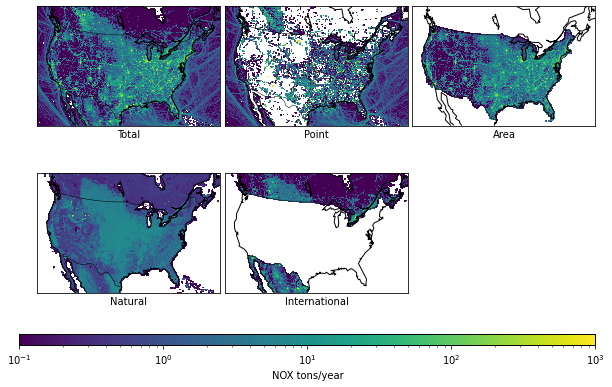

In [274]:
key = 'NOX'
norm = mc.LogNorm(vmin=1e-1, vmax=1e3)
fig, axx = plt.subplots(2, 3, gridspec_kw=dict(hspace=.05, wspace=0.025), figsize=(10, 6))
cax = fig.add_axes([0.1, 0.05, .8, .025])
plotopt = dict(norm=norm)
cbaropt = dict(label='{} tons/year'.format(key), cax=cax, orientation='horizontal')
plt.sca(axx[0, 0])
mergedfiles['merge'].plot(key, plot_kw=plotopt, cbar_kw=cbaropt).set_xlabel('Total')
plt.sca(axx[0, 1])
mergedfiles['merge_point'].plot(key, plot_kw=plotopt, cbar_kw=cbaropt).set_xlabel('Point')
plt.sca(axx[0, 2])
mergedfiles['merge_areaonly'].plot(key, plot_kw=plotopt, cbar_kw=cbaropt).set_xlabel('Area')
plt.sca(axx[1, 0])
mergedfiles['merge_natural'].plot(key, plot_kw=plotopt, cbar_kw=cbaropt).set_xlabel('Natural')
plt.sca(axx[1, 1])
mergedfiles['merge_intl'].plot(key, plot_kw=plotopt, cbar_kw=cbaropt).set_xlabel('International')
axx[1, 2].set_visible(False)

# Prepare for Regridding By Defining Grids

* EPA12US1.grid defines a Lambert Conic Conformal grid
* latlon.grid defines a regional latitude/longitude grid
* z.grid defines the first layer of GEOS-Chem's hybrid coordinate


In [275]:
lccpath = 'EPA12US1.grid'
llpath = 'latlon.grid'
with open(lccpath, mode='w') as gf:
  gf.write("""gridtype = projection
gridsize = {gridsize}
xsize = {NCOLS}
ysize = {NROWS}
xinc = {XCELL}
yinc = {YCELL}
xname = x
yname = y
grid_mapping_name = lambert_conformal_conic
latitude_of_projection_origin = {YCENT}
longitude_of_projection_origin = {XCENT}
longitude_of_central_meridian = {XCENT}
standard_parallel = {P_ALP}, {P_BET}
earth_radius = 6370000.
semi_major_axis = 6370000.
semi_minor_axis = 6370000.
false_easting = {false_easting}
false_northing = {false_northing}
""".format(**gridproperties))
  
with open(llpath, mode='w') as gf:
  gf.write("""gridtype  = lonlat
gridsize  = 340000
datatype  = float
xsize     = 850
ysize     = 400
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = -135
xinc      = 0.1
yfirst    = 20
yinc      = 0.1
""")
  
with open('z1.grid', mode='w') as gf:
  gf.write("""zaxistype = hybrid
size = 1
vctsize = 4
levels = 1
vct = 0.000000e+00 6.436264e+01 1.000000e+00 7.706375e-01
""")

# Initialize the CDO Library and Prepare Command

* Initialization is easy
* You may get a warning  


In [276]:
from cdo import Cdo
cdo = Cdo()

# Now Configure the CDO Command

cmd has 5 parts (run and described in bottom-to-top order)

* Set the vertical axis,
* rename TSTEP axis to time, remove TFLAG, set the time
* convert from tons/year to tons/s, tons/m2/s, then kg/m2/s
* Set units to mass fluxes
* Set grid to LCC and Regrid to the lon/lat grid


In [277]:
cmdtmpl = (
    '-remapycon,{llpath} -setgrid,{lccpath} ' + # assign LCC grid and regrid
    '-setattribute,NOX@units=kgNO2/m2/s -setattribute,NO@units=kgNO2/m2/s -setattribute,units=kg/m2/s ' + # fix units
    '-mulc,{unitconversion} -divc,{nominalarea} -divc,{seconds} ' + # convert tons/year to kg/m2/s
    '-setreftime,1970-01-01,00:00:00,hours -settaxis,2016-01-01,00:00:00 -delname,TFLAG -chname,TSTEP,time ' + # fix time properties
    '-setzaxis,z1.grid -chname,LAY,levels {inpath}' # fix dimensions
)

# Regrid Each file

* Using cmd described above and applying 0 to missing values
* Output
  * NetCDF4
  * grid chunking
  * level 1 compressions


In [278]:
remakeall = False
fileopts = '-O -f nc4 -k grid -z zip_1'
os.makedirs('output', exist_ok=True)
options = dict(
  llpath=llpath, lccpath=lccpath, nominalarea=gridproperties['nominalarea'],
  unitconversion=907.185
)

cdo_sectors = include_sectors + list(mergedfiles)

for sector in cdo_sectors:
  inpath = filetmpl % (sector, month)
  outpath = 'output/' + inpath.replace('12US1', '0pt1degree')
  if os.path.exists(outpath) and not remakeall:
    print('Keeping cached:', outpath)
    continue
  else:
    print(outpath, end='', flush=True)
  f = pnc.pncopen(inpath, format='ioapi')
  sdate = f.getTimes()[0]
  ndays = monthrange(sdate.year, sdate.month)[1]
  options['seconds'] = ndays * 24 * 3600
  !rm -f {outpath}
  cmd= cmdtmpl.format(inpath=inpath, **options)
  cdo.setmisstoc(0, input=cmd, output=outpath, options=fileopts)
  print('.done', flush=True)
print('Success: all complete')

output/2016fh_16j_afdust_adj_0pt1degree_month_08.ncf.done
output/2016fh_16j_ag_0pt1degree_month_08.ncf.done
output/2016fh_16j_airports_0pt1degree_month_08.ncf.done
output/2016fh_16j_nonpt_0pt1degree_month_08.ncf.done
output/2016fh_16j_nonroad_0pt1degree_month_08.ncf.done
output/2016fh_16j_np_oilgas_0pt1degree_month_08.ncf.done
output/2016fh_16j_onroad_0pt1degree_month_08.ncf.done
output/2016fh_16j_onroad_ca_adj_0pt1degree_month_08.ncf.done
output/2016fh_16j_rail_0pt1degree_month_08.ncf.done
output/2016fh_16j_rwc_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_cmv_c3_12_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_othpt_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_ptegu_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_pt_oilgas_allinln_0pt1degree_month_08.ncf.done
output/2016fh_16j_emln_ptnonipm_allinln_0pt1degree_month_08.ncf.done
output/2016fh_16j_onroad_can_0pt1degree_month_08.ncf.done
output/2016fh_

# Check Mass Conservation

* Calculate the Mass from Regridded Fluxes
* Get the Area of the New Grid
* Convert to mass comparable to CMAQ
  * Multiply the area by the fluxes
  * Convert per second rates to per year
  * Convert kg to short tons



In [279]:
areaf = cdo.gridarea(llpath, input='-remapnn,%s -stdatm,0' % llpath, options='-f nc4', returnCdf=True)
area = areaf.variables['cell_area'][:]

In [280]:
hemco2dfiles = {
  sector: pnc.pncopen('output/' + filetmpl.replace('12US1', '0pt1degree') % (sector, month), format='netcdf', mode='r')
  for sector in include_sectors
}

hemco2dmergedfiles = {
  sector: pnc.pncopen('output/' + filetmpl.replace('12US1', '0pt1degree') % (sector, month), format='netcdf', mode='r')
  for sector in list(mergedfiles)
}
hemco2dNOXrate = {}
for sector in include_sectors:
  sfile = hemco2dfiles[sector]
  if 'NOX' not in sfile.variables:
    continue
  sdate =  sfile.getTimes()[0]
  ndays = monthrange(sdate.year, sdate.month)[1]
  nox = (sfile.variables['NOX'][:].sum((0, 1)) * area).sum() * ndays * 24 * 3600 * 0.00110231
  hemco2dNOXrate[sector] = nox

hemco2dmergedNOXrate = {}
for sector in list(mergedfiles):
  sfile = hemco2dmergedfiles[sector]
  if 'NOX' not in sfile.variables:
    continue
  sdate =  sfile.getTimes()[0]
  ndays = monthrange(sdate.year, sdate.month)[1]
  nox = (sfile.variables['NOX'][:].sum((0, 1)) * area).sum() * ndays * 24 * 3600 * 0.00110231
  hemco2dmergedNOXrate[sector] = nox


In [281]:
hemco2dNOXrate
hemco2dtotal = sum(hemco2dNOXrate.values())
hemco2dmergedtotal = (hemco2dmergedNOXrate['merge_areaonly'] + hemco2dmergedNOXrate['merge_point'] + hemco2dmergedNOXrate['merge_intl'])
print('ORIG', mergedNOXrate['merge'])
print('HEMCO2D', hemco2dtotal)
print('HEMCO2D', hemco2dmergedtotal)
print('ORIG/HEMCO2D', hemco2dtotal / mergedNOXrate['merge'])
hemco2dmergedNOXrate

ORIG 1125362.5
HEMCO2D 1121542.4877536888
HEMCO2D 1121542.4882075365
ORIG/HEMCO2D 0.9966055273333604


{'merge': 1121542.4869326097,
 'merge_areaonly': 582157.8416614836,
 'merge_intl': 123777.06478523479,
 'merge_natural': 252774.8314258596,
 'merge_point': 415607.581760818}

In [282]:
for key in 'NOX APIN BPIN ISOP SESQ TERP'.split():
  for sector in include_sectors:
    sfile = hemco2dfiles[sector]
    if key not in sfile.variables:
        continue
    vals = sfile.variables[key][:]
    print('{}: {} sum={:.7g}'.format(sector, key, (vals * area).sum() * 3600 * 24 * 366 * 0.00110231))


airports: NOX sum=198757.2
nonpt: NOX sum=377468
nonroad: NOX sum=1434619
np_oilgas: NOX sum=561744.1
onroad: NOX sum=3452283
onroad_ca_adj: NOX sum=253179.9
rail: NOX sum=591027
rwc: NOX sum=4139.904
emln_cmv_c1c2_12: NOX sum=239142.1
emln_cmv_c3_12: NOX sum=720973.3
emln_othpt: NOX sum=1001893
emln_ptegu: NOX sum=1612157
emln_pt_oilgas_allinln: NOX sum=388357.1
emln_ptnonipm_allinln: NOX sum=944328.2
onroad_can: NOX sum=410345.6
onroad_mex: NOX sum=424908
othar: NOX sum=626114.4
ag: ISOP sum=958.9598
airports: ISOP sum=1.408277
nonpt: ISOP sum=217.6594
nonroad: ISOP sum=2137.425
np_oilgas: ISOP sum=1.142131
onroad: ISOP sum=1033.049
onroad_ca_adj: ISOP sum=59.3442
rail: ISOP sum=49.25654
rwc: ISOP sum=122.5423
emln_cmv_c1c2_12: ISOP sum=89.60066
emln_cmv_c3_12: ISOP sum=386.0085
emln_othpt: ISOP sum=181.1257
emln_ptegu: ISOP sum=1.532864
emln_pt_oilgas_allinln: ISOP sum=5.557787
emln_ptnonipm_allinln: ISOP sum=713.8114
onroad_can: ISOP sum=33.73562
onroad_mex: ISOP sum=82.7006
othar:

# Plot Results

* Always good to take a look at NOX
* Showing 2D results

**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  Bounds is an approximation assuming lon variable is cell centers
**PNC:/usr/local/lib/python3.6/dist-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  Bounds is an approximation assuming lat variable is cell centers


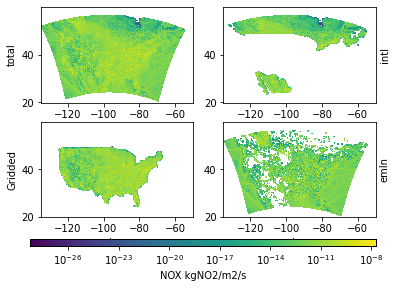

In [283]:
spc = 'NOX'
fig, axx = plt.subplots(2, 2, gridspec_kw=dict(bottom=0.15))
cax = fig.add_axes([.1, .05, .8, .025])
plotopts=dict(norm=mc.LogNorm())
cbaropts = dict(cax=cax, orientation='horizontal')
plt.sca(axx[0, 0])
hemco2dmergedfiles['merge'].plot(spc, plottype='lon-lat', plot_kw=plotopts, cbar_kw=cbaropts)
axx[0, 0].set_ylabel("total")
plt.sca(axx[1, 0])
hemco2dmergedfiles['merge_areaonly'].plot(spc, plottype='lon-lat', plot_kw=plotopts, cbar_kw=cbaropts)
axx[1, 0].set_ylabel('Gridded')
plt.sca(axx[1, 1])
hemco2dmergedfiles['merge_point'].plot(spc, plottype='lon-lat', plot_kw=plotopts, cbar_kw=cbaropts)
axx[1, 1].set_ylabel('emln')
axx[1, 1].yaxis.set_label_position("right")
plt.sca(axx[0, 1])
hemco2dmergedfiles['merge_intl'].plot(spc, plottype='lon-lat', plot_kw=plotopts, cbar_kw=cbaropts)
axx[0, 1].set_ylabel('intl')
axx[0, 1].yaxis.set_label_position("right")


In [284]:
import pandas as pd
import io

vertical_allocation = pd.read_csv(io.StringIO("""L,bottom_m,top_m,othpt,ptegu,ptnonipm,pt_oilgas,ptfire,cmv_c3
1,-6,123,0.806067059,0.027331187,0.751204553,0.918700528,0.11976381,0.537538889
2,123,254,0.087955253,0.12260809,0.144224191,0.059678397,0.098297847,0.338982929
3,254,387,0.053252808,0.192017292,0.052822078,0.013323237,0.08277491,0.123478182
4,387,521,0.025605531,0.212736741,0.023840537,0.003978944,0.074659995,0
5,521,657,0.011408677,0.167549199,0.011000364,0.001724366,0.077561337,0
6,657,795,0.005787852,0.110491495,0.005661267,0.001038275,0.073349589,0
7,795,934,0.003758579,0.063653198,0.003165207,0.000633395,0.066694526,0
8,934,1075,0.002673887,0.036979211,0.00197344,0.000387233,0.061845442,0
9,1075,1218,0.001675656,0.022844579,0.001300664,0.000243355,0.058324971,0
10,1218,1363,0.000670159,0.013909341,0.000861865,0.000122994,0.053902287,0
11,1363,1510,0.000357644,0.008781226,0.000621856,6.48583E-05,0.044774262,0
12,1510,1659,0.00022693,0.006647819,0.00052355,4.04985E-05,0.041122289,0
13,1659,1860,0.000159139,0.004305749,0.000466642,2.12041E-05,0.0306914,0
14,1860,2118,0.000152154,0.003380562,0.000680222,1.75333E-05,0.031529605,0
15,2118,2382,0.000113674,0.001827346,0.000612964,1.03278E-05,0.02551535,0
16,2382,2654,8.79442E-05,0.000957313,0.000260885,5.76406E-06,0.020748307,0
17,2654,2932,3.14778E-05,0.000523901,0.000311535,3.23215E-06,0.014366484,0
18,2932,3219,1.29957E-05,0.000381747,0.000231719,2.27428E-06,0.010906613,0
19,3219,3665,1.37334E-06,0.000409744,0.000115745,1.78044E-06,0.009224629,0
20,3665,4132,3.15633E-07,0.000340645,4.19637E-05,6.00909E-07,0.003409241,0
21,4132,4623,3.71912E-07,0.00026689,1.84353E-05,4.14262E-07,0.00014894,0
22,4623,5142,4.01952E-07,0.000231509,1.03385E-05,3.73296E-07,0.000125351,0
23,5142,5692,1.17457E-07,0.000225471,9.11318E-06,3.01765E-07,8.76892E-05,0
24,5692,6277,0,0.000310076,9.82452E-06,1.13299E-07,3.24343E-05,0
25,6277,6905,0,0.000327088,1.07925E-05,0,3.0049E-05,0
26,6905,7582,0,0.000260516,1.2311E-05,0,2.85539E-05,0
27,7582,8320,0,0.000130502,4.58591E-06,0,2.08973E-05,0
28,8320,9409,0,0.000119402,2.72213E-06,0,3.26732E-05,0
29,9409,10504,0,0.000106184,6.30588E-07,0,1.74394E-05,0
30,10504,11578,0,9.07766E-05,0,0,1.30783E-05,0
31,11578,12633,0,0.000117164,0,0,0,0
32,12633,13674,0,0.000122616,0,0,0,0
33,13674,14706,0,1.54213E-05,0,0,0,0
34,14706,15731,0,0,0,0,0,0
35,15731,16753,0,0,0,0,0,0
36,16753,17773,0,0,0,0,0,0
37,17773,19855,0,0,0,0,0,0
38,19855,22004,0,0,0,0,0,0
39,22004,24240,0,0,0,0,0,0
40,24240,26596,0,0,0,0,0,0
41,26596,31716,0,0,0,0,0,0
42,31716,37574,0,0,0,0,0,0
43,37574,44286,0,0,0,0,0,0
44,44286,51788,0,0,0,0,0,0
45,51788,59924,0,0,0,0,0,0
46,59924,68392,0,0,0,0,0,0
47,68392,80581,0,0,0,0,0,0
""")).set_index(['L'])

nl = 11
vertical_allocation_layers = vertical_allocation.loc[1:nl]
vertical_allocation_layer_fraction = vertical_allocation_layers / vertical_allocation_layers.sum()

# Add Vertical Allocation

* Oversimplifying vertical allocation
  * all emln emissions based on energy sector from a single report
  * Simpson D., Fagerli, H., Jonson, J. E., Tsyro, S., Wind, P., and Tuovinen, J.: "Transboundary Acidification, Eutrophication, and Ground Level Ozone in Europe - Part I: Unified EMEP Model Description”, EMEP Status Report 2003, The  Norwegian Meteorological Institute, Oslo, 25 Norway, 2003.
* Manually fixing meta data
  * (hyai, hybi, and lev)
  * renaming dimensions to ilev

In [285]:
import gc


sector2verticalallocation = {
  'emln_cmv_c1c2_12': 'cmv_c3',
  'emln_cmv_c3_12': 'cmv_c3',
  'emln_othpt': 'othpt',
  'emln_pt_oilgas_allinln': 'pt_oilgas',
  'emln_ptegu': 'ptegu',
  'emln_ptnonipm_allinln': 'ptnonipm'
}

for sector in ptonly_sectors + allinln_sectors:
  gc.collect()
  inpath = 'output/' + (filetmpl % (sector, month)).replace('12US1', '0pt1degree')
  outpath = inpath.replace('0pt1degree', '0pt1degree_3D')
  origlayerfractions = vertical_allocation_layer_fraction[sector2verticalallocation[sector]].values
  nl = (origlayerfractions == 0).argmax()
  if nl == 0:
    nl = len(origlayerfractions)
  layerfractions = origlayerfractions[:nl]
  layerfractions /= layerfractions.sum()
  print(sector, origlayerfractions)
  print(sector, nl, layerfractions)
  print('Start.', outpath, end='')
  !rm -f {outpath}
  emln2df = pnc.pncopen(inpath, format='netcdf')
  emln3df = emln2df.sliceDimensions(lev=[0] * nl).sliceDimensions(nhym=[0] * nl).sliceDimensions(nhyi=[0] * (nl + 1))
  for key, var in emln3df.variables.items():
    if 'lev' in var.dimensions:
      newshape = tuple([(slice(None) if dk == 'lev' else None) for dk in var.dimensions])
      var[:] = var[:] * layerfractions[newshape]

  hyai = emln3df.variables['hyai'][:] = [
    0.000000e+00, 4.804826e-02, 6.593752e+00, 1.313480e+01, 1.961311e+01, 2.609201e+01,
    3.257081e+01, 3.898201e+01, 4.533901e+01, 5.169611e+01, 5.805321e+01, 6.436264e+01
  ][:nl+1]
  hybi = emln3df.variables['hybi'][:] = [
    1.000000e+00, 9.849520e-01, 9.634060e-01, 9.418650e-01, 9.203870e-01, 8.989080e-01,
    8.774290e-01, 8.560180e-01, 8.346609e-01, 8.133039e-01, 7.919469e-01, 7.706375e-01
  ][:nl+1]
  emln3df.variables['hybm'][:] = np.convolve([.5, .5], hybi, mode='valid')
  emln3df.variables['hyam'][:] = np.convolve([.5, .5], hyai, mode='valid')
  emln3df.variables['lev'][:] = np.arange(nl, dtype='i') + 1
  outnc = emln3df.save(outpath, verbose=0)
  outnc.close()
  print('.Complete')

emln_cmv_c1c2_12 [0.53753889 0.33898293 0.12347818 0.         0.         0.
 0.         0.         0.         0.         0.        ]
emln_cmv_c1c2_12 3 [0.53753889 0.33898293 0.12347818]
Start. output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_3D_month_08.ncf

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


.Complete
emln_cmv_c3_12 [0.53753889 0.33898293 0.12347818 0.         0.         0.
 0.         0.         0.         0.         0.        ]
emln_cmv_c3_12 3 [0.53753889 0.33898293 0.12347818]
Start. output/2016fh_16j_emln_cmv_c3_12_0pt1degree_3D_month_08.ncf.Complete
emln_othpt [8.06701849e-01 8.80245191e-02 5.32947454e-02 2.56256957e-02
 1.14176615e-02 5.79241002e-03 3.76153894e-03 2.67599273e-03
 1.67697560e-03 6.70686760e-04 3.57925650e-04]
emln_othpt 11 [8.06701849e-01 8.80245191e-02 5.32947454e-02 2.56256957e-02
 1.14176615e-02 5.79241002e-03 3.76153894e-03 2.67599273e-03
 1.67697560e-03 6.70686760e-04 3.57925650e-04]
Start. output/2016fh_16j_emln_othpt_0pt1degree_3D_month_08.ncf.Complete
emln_ptegu [0.02792026 0.12525068 0.19615588 0.21732189 0.17116042 0.11287294
 0.06502513 0.03777623 0.02333695 0.01420913 0.00897049]
emln_ptegu 11 [0.02792026 0.12525068 0.19615588 0.21732189 0.17116042 0.11287294
 0.06502513 0.03777623 0.02333695 0.01420913 0.00897049]
Start. output/2016fh_16

# Now Do a Mass Conservation Check

* Open the 3d file
* Open the reference file
* Sum the values and compare

In [291]:
from glob import glob

emln3dpaths = sorted(glob('output/*_3D_*.ncf'))
for inpath in emln3dpaths:
  refpath = inpath.replace('_3D', '')
  f3d = pnc.pncopen(inpath)
  fref = pnc.pncopen(refpath)
  print(refpath)
  print('emln   {:2d} lev NOX {:.7e} sum kgNO2/m2/s'.format(len(fref.dimensions['lev']), fref.variables['NOX'][:].sum()))
  print('emln3d {:2d} lev NOX {:.7e} sum kgNO2/m2/s'.format(len(f3d.dimensions['lev']), f3d.variables['NOX'][:].sum()))
  print('Within numerical precission', np.allclose(fref.variables['NOX'][:, 0], f3d.variables['NOX'][:].sum(1)))

output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_01.ncf
emln    1 lev NOX 4.7244960e-08 sum kgNO2/m2/s
emln3d  3 lev NOX 4.7244953e-08 sum kgNO2/m2/s
Within numerical precission True
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_02.ncf
emln    1 lev NOX 5.5669542e-08 sum kgNO2/m2/s
emln3d  3 lev NOX 5.5669549e-08 sum kgNO2/m2/s
Within numerical precission True
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_03.ncf
emln    1 lev NOX 5.5620237e-08 sum kgNO2/m2/s
emln3d  3 lev NOX 5.5620234e-08 sum kgNO2/m2/s
Within numerical precission True
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_04.ncf
emln    1 lev NOX 5.9835529e-08 sum kgNO2/m2/s
emln3d  3 lev NOX 5.9835543e-08 sum kgNO2/m2/s
Within numerical precission True
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_05.ncf
emln    1 lev NOX 6.5473522e-08 sum kgNO2/m2/s
emln3d  3 lev NOX 6.5473522e-08 sum kgNO2/m2/s
Within numerical precission True
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_month_06.ncf
emln    1 l

# Configure Translation from CMAQ to GEOS-Chem

* Translation is not always 1:1
* Apply scaling factors
  * Diurnal scale factors (25, 26)
  * Day of week (210-222)
  * Split OC/EC (70-73)
  * Convert NO kgNO2/m2/s to kgNO/m2/s (115)

In [287]:
cq2gc = {
    'ACET': [['ACET', '26/213/1007']],
    'ALD2': [['ALD2', '26/213/1007']],
    'ALDX': [['RCHO', '26/213/1007']],
    'ACROLEIN': [['MACR', '26/213//1007']],
    'BENZ': [['BENZ', '26/213/1007']],
    'ECH4': [['CH4', '1007']],
    'CL': [['Cl', '1007']],
    'CL2': [['Cl2', '1007']],
    'CLO': [['ClO', '1007']],
    'CLNO2': [['ClNO2', '1007']],
    'CLNO3': [['ClNO3', '1007']],
    'CO': [['CO', '26/211/1007']],
    'ETOH': [['EOH', '26/213/1007']],
    'ETHA': [['C2H6', '26/217/1007']],
    'ETH': [['C2H4', '26/213/1007']],
    'FACD': [['HCOOH', '26/213/1007']],
    'FORM': [['CH2O', '26/213/1007']],
    'GLY': [['GLYX', '26/214/1007']], # Following MEK
    'GLYD': [['GLYC', '26/214/1007']], # Following MEK
    'HCL': [['HCl', '1007']],
    'HOCL': [['HOCl', '1007']],
    'HONO': [['HNO2', '25/210/1007']],
    'HPLD': [['HPALD', '26/214/1007']], # Following MEK
    'IOLE': [['PRPE', '26/215/1007']],
    'KET': [['MEK', '26/214/1007']],
    'MEPX': [['MP', '26/213/1007']], # Following MEOH
    'MEOH': [['MOH', '26/213/1007']],
    'NH3': [['NH3', '26/213/1007']],
    'NO': [['NO', '115/25/210/1007']],
    'NO2': [['NO2', '25/210/1007']],
    'OLE': [['PRPE', '26/215/1007']],
    'PACD': [['MAP', '26/213/1007']], # Following MEOH
    'PAR': [['ALK4', '26/212/1007']],
    'PNA': [['HNO4', '26/213/1007']], # Following MEOH
    'PRPA': [['C3H8', '26/216/1007']],
    'SO2': [['SO2', '26/218/1007']],
    'SULF': [['SO4', '26/218/1007']],
    'TOL': [['TOLU', '26/213/1007']],
    'PEC': [['BCPI', '26/221/1007/70'], ['BCPO', '26/221/256/1007/71']],
    'PFE': [['pFe', '26/219/1007']],
    'POC': [['OCPI', '26/222/1007/72'], ['OCPO', '26/222/257/1007/73']],
    'PNH4': [['NH4', '26/218/1007']], # need to confirm this
    'PNO3': [['NIT', '26/218/1007']], # need to confirm this
    'PSO4': [['SO4', '26/219/1007']],
    'XYLMN': [['XYLE', '26/213/1007']],
}
# Ignore special species
exec('ALD2_PRIMARY = FORM_PRIMARY = NH3_FERT = []', None, cq2gc)
# ignore inventory meta variables
exec('HFLUX = VOC_INV = VOC_BEIS = CO2_INV = N2O_INV = CH4_INV = []', None, cq2gc)
# Ignore duplicative species
# TOLU in TOL
# NOX = NO + NO2 + HONO
# CH4 in ECH4
exec('CH4 = TOLU = NOX = []', None, cq2gc)
# Ignore APIN, BPIN, and SESQ - they were from BEIS
# and were removed
exec('APIN = BPIN = SESQ = []', None, cq2gc)
# ISOP and TERP are mostly biogenic, so igoring remainder
exec('ISOP = TERP = []', None, cq2gc)
# Ignore species GC doesn't have
exec('BUTADIENE13 = ETHY = NAPH = []', None, cq2gc)
# unreactive and nonvolatile are not used
exec('UNK = UNR = NVOL = NR = []', None, cq2gc)
# Ignore unused particulate species
exec('SOAALK = PAL = PCA = PCL = PFE = PH2O = PK = PSI = PTI = []', None, cq2gc)
exec('PM2_5 = PMC = PMG = PMN = PMOTHR = PNCOM = P = PCA = PCL = PFE = PH2O = PK = []', None, cq2gc)

# Choose paths to use in HEMCO

* hemco3d files take precedence
* hemco2d are the default
* Must have one or the other

In [288]:
hcpaths = []
for sector in include_sectors:
  smokepath = filetmpl % (sector, month)
  hemco2dpath = 'output/' + smokepath.replace('12US1', '0pt1degree')
  hemco3dpath = hemco2dpath.replace('0pt1degree', '0pt1degree_3D')
  if os.path.exists(hemco3dpath):
    hcpaths.append(hemco3dpath)
  elif os.path.exists(hemco2dpath):
    hcpaths.append(hemco2dpath)
  else:
    raise KeyError('Could not find regridded: ' + hemco2dpath)


# Write HEMCO_Config.rc

* Create a HEMCO_Config.rc that reads all included files
* Only needed to be made once and editted to use $MM instead of 01..12


In [289]:
def changepathtopattern(path):
  return path.replace('month_' + month, 'month_$MM')

defaults = set()
ignores = set()
with open('output/EPA_Config.rc', 'w') as hcf:
  hcf.write('(((EPA2016_MONMEAN\n')
  for hcpath in hcpaths:
    print(hcpath, end='', flush=True)
    hcfile = pnc.pncopen(hcpath, format='netcdf')
    hcpath = changepathtopattern(hcpath)
    for cqkey, v in hcfile.variables.items():
      if cqkey in hcfile.dimensions or cqkey in ('hyai', 'hybi'):
        continue
      elif cqkey in ('TOLU',):
        warn('TOLU mass is duplicated by TOL')
      if cqkey in cq2gc:
        gctrans = cq2gc.get(cqkey)
        if len(gctrans) == 0:
          ignores.add(cqkey)
      else:
        defaults.add(cqkey)
        gctrans = [[cqkey, '1007']]
      for gckey, scale in gctrans:
        opts = dict(
            unit=v.units.strip(),
            gckey=gckey,
            cqkey=cqkey,
            sector=hcpath.split('_')[2],
            path='{HCROOT}/NEI2016fh/' + hcpath,
            scale=scale,
            cat='1',
            hier=50
        )
        hcf.write('0 EPA16_{sector}_{cqkey}_{gckey} {path}  {cqkey}       2016-2016/1-12/1-31/1-24 C xyz  {unit}  {gckey}   {scale}     {cat} {hier}\n'.format(**opts))
    print()
  hcf.write(')))EPA2016_MONMEAN\n')
print('Ignored', sorted(ignores))
print('Defaults', sorted(defaults))

output/2016fh_16j_afdust_adj_0pt1degree_month_08.ncf
output/2016fh_16j_ag_0pt1degree_month_08.ncf
output/2016fh_16j_airports_0pt1degree_month_08.ncf
output/2016fh_16j_nonpt_0pt1degree_month_08.ncf
output/2016fh_16j_nonroad_0pt1degree_month_08.ncf
output/2016fh_16j_np_oilgas_0pt1degree_month_08.ncf
output/2016fh_16j_onroad_0pt1degree_month_08.ncf
output/2016fh_16j_onroad_ca_adj_0pt1degree_month_08.ncf
output/2016fh_16j_rail_0pt1degree_month_08.ncf
output/2016fh_16j_rwc_0pt1degree_month_08.ncf
output/2016fh_16j_emln_cmv_c1c2_12_0pt1degree_3D_month_08.ncf
output/2016fh_16j_emln_cmv_c3_12_0pt1degree_3D_month_08.ncf
output/2016fh_16j_emln_othpt_0pt1degree_3D_month_08.ncf
output/2016fh_16j_emln_ptegu_0pt1degree_3D_month_08.ncf
output/2016fh_16j_emln_pt_oilgas_allinln_0pt1degree_3D_month_08.ncf
output/2016fh_16j_emln_ptnonipm_allinln_0pt1degree_3D_month_08.ncf
output/2016fh_16j_onroad_can_0pt1degree_month_08.ncf
output/2016fh_16j_onroad_mex_0pt1degree_month_08.ncf
output/2016fh_16j_othafdust_

# Review the HEMCO file

In [290]:
less output/EPA_Config.rc

/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py:342: ResourceWarning: unclosed file <_io.TextIOWrapper name='output/EPA_Config.rc' mode='r' encoding='UTF-8'>
  cont = open(arg_s).read()


# Summary

You've created 3 important in the output folder.
1. A 3D emln file with no fires.
2. A 2D gridded file with no beis
3. A HEMCO_Config.rc file

The are two additional files that are just references:
1. tot_nobeis_nofire is a refernce fo the expected total
2. emln_nofire (non-3D)

Download the output directory

In [292]:
from google.colab import files

!zip -r /content/output.zip /content/output/
files.download("/content/output.zip")


updating: content/output/ (stored 0%)
updating: content/output/2016fh_16j_emln_pt_oilgas_allinln_0pt1degree_month_02.ncf (deflated 14%)
updating: content/output/2016fh_16j_merge_areaonly_0pt1degree_month_07.ncf (deflated 3%)
updating: content/output/2016fh_16j_emln_pt_oilgas_allinln_0pt1degree_3D_month_07.ncf (deflated 97%)
updating: content/output/2016fh_16j_emln_cmv_c3_12_0pt1degree_3D_month_07.ncf (deflated 91%)
updating: content/output/2016fh_16j_emln_ptnonipm_allinln_0pt1degree_3D_month_07.ncf (deflated 93%)
updating: content/output/2016fh_16j_emln_cmv_c3_12_0pt1degree_3D_month_02.ncf (deflated 92%)
updating: content/output/2016fh_16j_np_oilgas_0pt1degree_month_01.ncf (deflated 13%)
updating: content/output/2016fh_16j_nonroad_0pt1degree_month_07.ncf (deflated 3%)
updating: content/output/2016fh_16j_nonpt_0pt1degree_month_07.ncf (deflated 3%)
updating: content/output/2016fh_16j_othptdust_adj_0pt1degree_month_07.ncf (deflated 11%)
updating: content/output/2016fh_16j_emln_othpt_0pt1d

MessageError: ignored